In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community.community_louvain as community_louvain # Richiede il pacchetto python-louvain
from collections import Counter

# Configurazione stile visualizzazioni
sns.set_theme(style="whitegrid", context="notebook", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

print("✓ Librerie importate con successo.")

✓ Librerie importate con successo.


In [2]:
# 1. Caricamento del Grafo
# Carichiamo il grafo salvato in formato GML dal notebook precedente
try:
    G = nx.read_gml('../data/cyber_incidents_graph.gml')
    print(f"✓ Grafo caricato correttamente.")
    print(f"  - Nodi (Paesi): {G.number_of_nodes()}")
    print(f"  - Archi (Attacchi): {G.number_of_edges()}")
    
    # Verifica se il grafo è diretto
    if nx.is_directed(G):
        print("  - Tipo: Diretto")
    else:
        print("  - Tipo: Non diretto")
        
except FileNotFoundError:
    print("❌ Errore: Il file '../data/cyber_incidents_graph.gml' non è stato trovato.")
    print("   Esegui prima il notebook '02_Cyber_Incidents_Graph.ipynb' per generare il grafo.")

✓ Grafo caricato correttamente.
  - Nodi (Paesi): 53
  - Archi (Attacchi): 81
  - Tipo: Diretto


In [3]:
# 2. Calcolo delle Metriche di Centralità
# Ricalcoliamo le metriche per averle disponibili in un DataFrame per l'analisi statistica

print("Calcolo delle metriche di centralità in corso...")

# Degree Centrality (In/Out per grafi diretti)
in_degree = nx.in_degree_centrality(G)
out_degree = nx.out_degree_centrality(G)

# Betweenness Centrality (misura quanto un nodo fa da "ponte")
betweenness = nx.betweenness_centrality(G, weight='weight')

# Closeness Centrality (vicinanza agli altri nodi)
closeness = nx.closeness_centrality(G)

# Eigenvector Centrality (influenza basata sulla connessione a nodi influenti)
try:
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000, weight='weight')
except:
    eigenvector = {node: 0 for node in G.nodes()} # Fallback se non converge

# Creazione DataFrame
metrics_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'In_Degree': [in_degree[n] for n in G.nodes()],
    'Out_Degree': [out_degree[n] for n in G.nodes()],
    'Betweenness': [betweenness[n] for n in G.nodes()],
    'Closeness': [closeness[n] for n in G.nodes()],
    'Eigenvector': [eigenvector[n] for n in G.nodes()]
})

# Aggiungiamo anche il grado grezzo (numero di connessioni)
metrics_df['In_Degree_Raw'] = [G.in_degree(n) for n in G.nodes()]
metrics_df['Out_Degree_Raw'] = [G.out_degree(n) for n in G.nodes()]

print("✓ Metriche calcolate e DataFrame creato.")
display(metrics_df.head())

Calcolo delle metriche di centralità in corso...
✓ Metriche calcolate e DataFrame creato.


,Country,In_Degree,Out_Degree,Betweenness,Closeness,Eigenvector,In_Degree_Raw,Out_Degree_Raw
0,China,0.057692,0.346154,0.110106,0.101171,0.074704,3,18
1,Australia,0.038462,0.000000,0.000000,0.095588,0.019227,2,0
2,Canada,0.038462,0.000000,0.000000,0.098901,0.022124,2,0
3,France,0.019231,0.019231,0.001131,0.079121,0.005978,1,1
4,Germany,0.038462,0.000000,0.000000,0.098901,0.124977,2,0


/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_2629/3969169218.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_eigen, x='Eigenvector', y='Country', palette='viridis', ax=axes[1, 0])


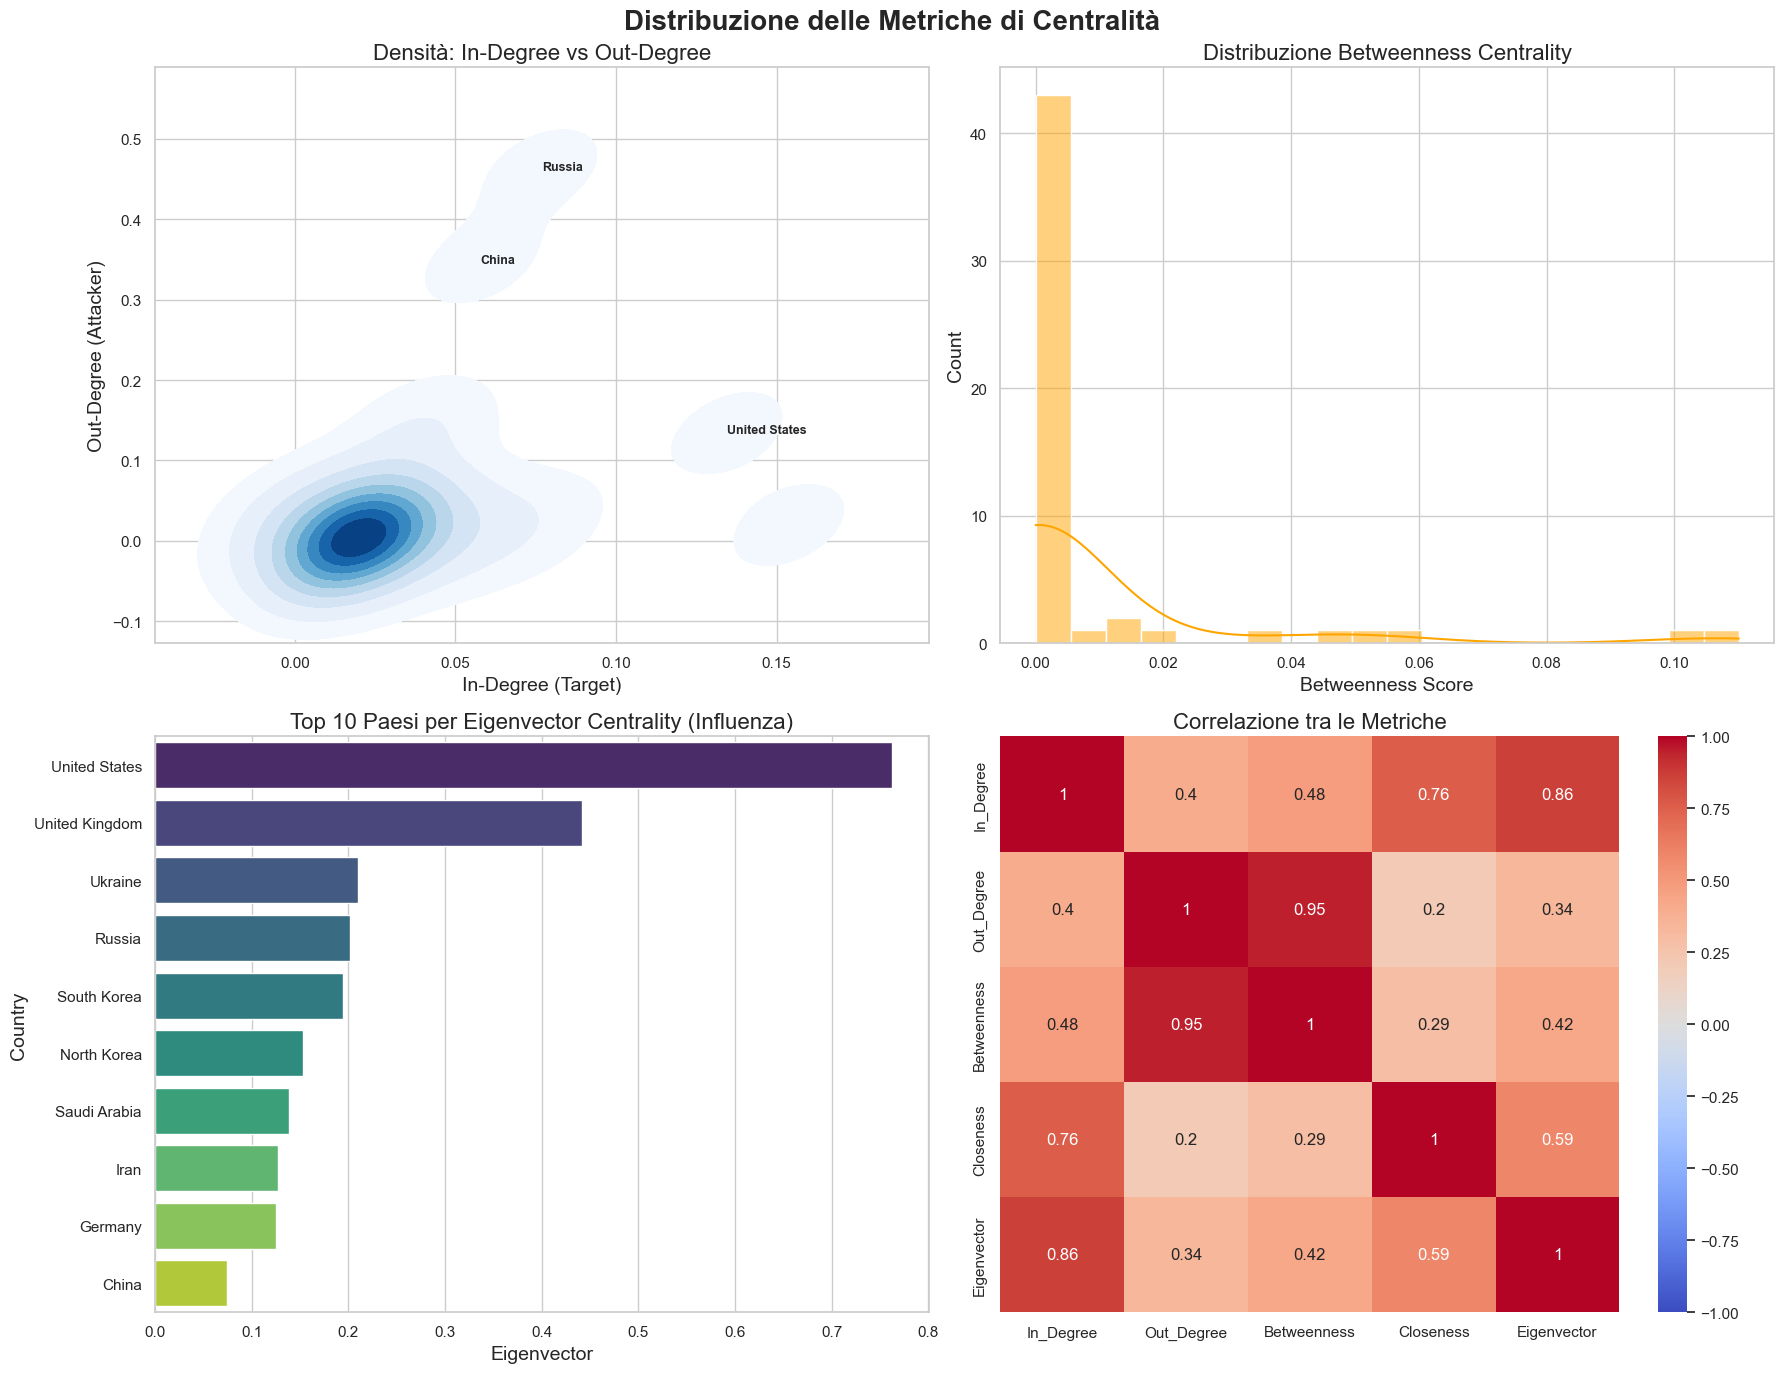

Generazione visualizzazione grafo basata su Spring Layout...


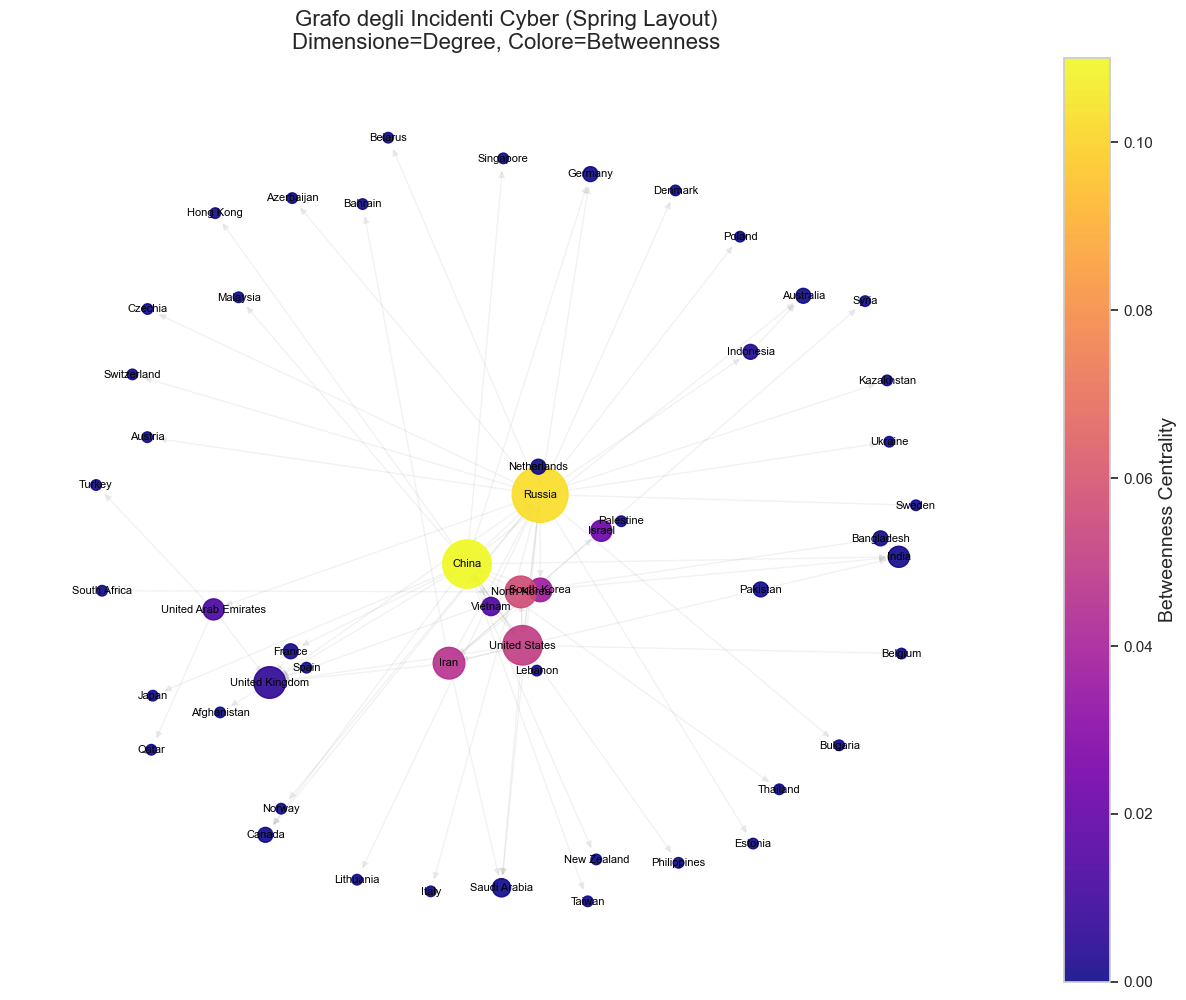

In [4]:
# 3. Visualizzazione Distribuzione Metriche (Seaborn) e Grafo Centralità
# Analizziamo come sono distribuite le metriche tra i vari paesi e visualizziamo il grafo pesato sulla centralità

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Distribuzione delle Metriche di Centralità', fontsize=20, fontweight='bold')

# Plot 1: In-Degree vs Out-Degree Distribution (KDE)
sns.kdeplot(data=metrics_df, x='In_Degree', y='Out_Degree', fill=True, cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Densità: In-Degree vs Out-Degree')
axes[0, 0].set_xlabel('In-Degree (Target)')
axes[0, 0].set_ylabel('Out-Degree (Attacker)')

# Annotiamo i paesi più estremi
top_active = metrics_df.nlargest(3, 'Out_Degree')
for _, row in top_active.iterrows():
    axes[0, 0].text(row['In_Degree'], row['Out_Degree'], row['Country'], fontsize=9, fontweight='bold')

# Plot 2: Betweenness Distribution (Histogram)
sns.histplot(data=metrics_df, x='Betweenness', bins=20, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribuzione Betweenness Centrality')
axes[0, 1].set_xlabel('Betweenness Score')

# Plot 3: Top 10 Countries by Eigenvector Centrality (Barplot)
top_eigen = metrics_df.nlargest(10, 'Eigenvector')
sns.barplot(data=top_eigen, x='Eigenvector', y='Country', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Paesi per Eigenvector Centrality (Influenza)')

# Plot 4: Correlation Matrix Heatmap
corr = metrics_df[['In_Degree', 'Out_Degree', 'Betweenness', 'Closeness', 'Eigenvector']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[1, 1])
axes[1, 1].set_title('Correlazione tra le Metriche')

plt.tight_layout()
plt.show()

# Visualizzazione del grafo con Spring Layout pesato sulla Betweenness Centrality
print("Generazione visualizzazione grafo basata su Spring Layout...")
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, seed=42, k=0.15)  # k regola la distanza tra i nodi

# Dimensione nodi basata su Degree
node_sizes = [v * 3000 for v in nx.degree_centrality(G).values()]

# Colore nodi basato su Betweenness
node_colors = [metrics_df.set_index('Country').loc[n, 'Betweenness'] for n in G.nodes()]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                               cmap=plt.cm.plasma, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.colorbar(nodes, label='Betweenness Centrality')
plt.title('Grafo degli Incidenti Cyber (Spring Layout)\nDimensione=Degree, Colore=Betweenness', fontsize=16)
plt.axis('off')
plt.show()

Numero totale di clique trovati: 54
Dimensione del clique più grande: 4
Numero di clique di dimensione massima: 4


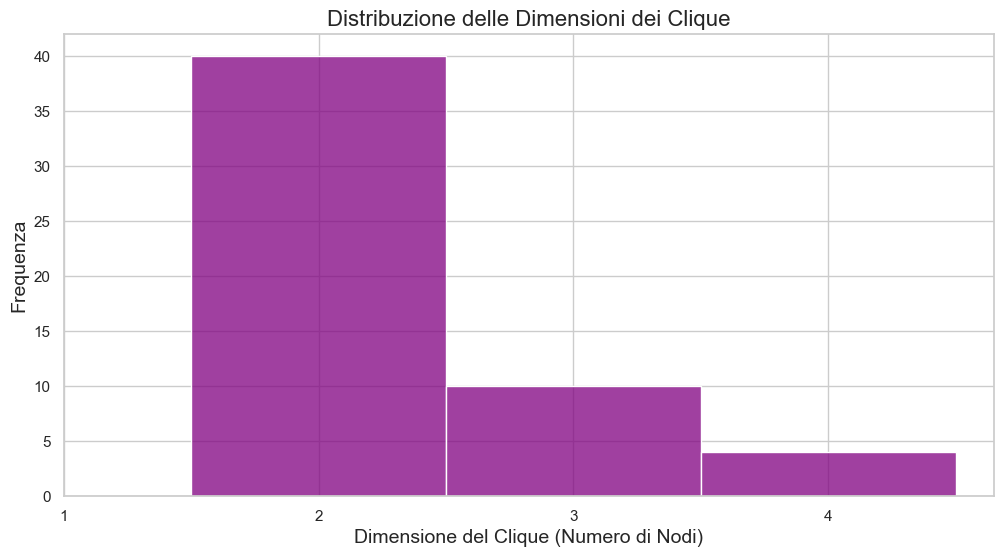

Paesi nel clique più grande:
['Russia', 'China', 'United Kingdom', 'United States']

Visualizzazione del Clique Massimo...


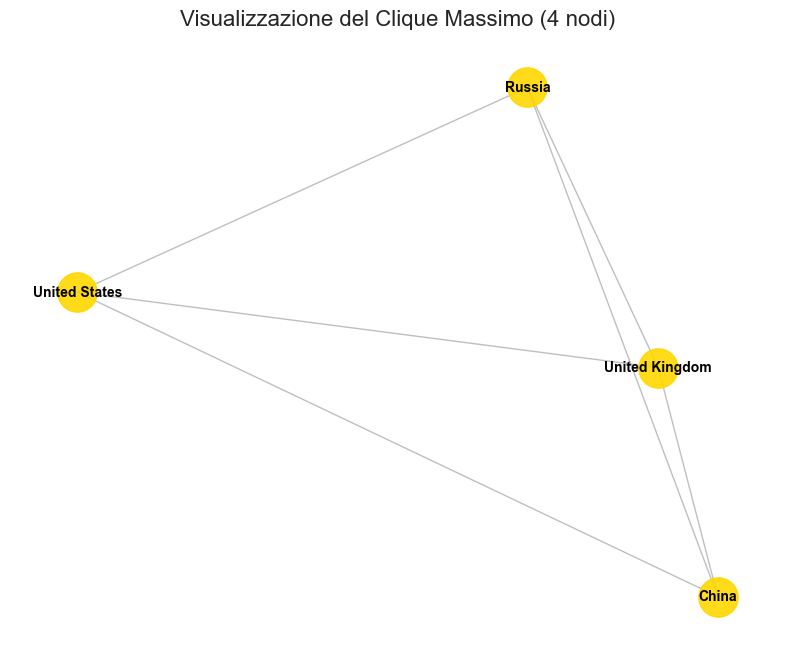

In [5]:
# 4. Analisi dei Clique e Visualizzazione del Clique Massimo
# Un clique è un sottografo in cui tutti i nodi sono connessi tra loro.
# Per questa analisi, convertiamo il grafo in non orientato.

G_undirected = G.to_undirected()
cliques = list(nx.find_cliques(G_undirected))

# Calcolo dimensioni dei clique
clique_sizes = [len(c) for c in cliques]
max_clique_size = max(clique_sizes)
max_cliques = [c for c in cliques if len(c) == max_clique_size]

print(f"Numero totale di clique trovati: {len(cliques)}")
print(f"Dimensione del clique più grande: {max_clique_size}")
print(f"Numero di clique di dimensione massima: {len(max_cliques)}")

# Visualizzazione distribuzione dimensioni clique
plt.figure(figsize=(12, 6))
sns.histplot(clique_sizes, bins=range(1, max_clique_size + 2), discrete=True, color='purple')
plt.title('Distribuzione delle Dimensioni dei Clique')
plt.xlabel('Dimensione del Clique (Numero di Nodi)')
plt.ylabel('Frequenza')
plt.xticks(range(1, max_clique_size + 1))
plt.show()

print("Paesi nel clique più grande:")
print(max_cliques[0])

# Visualizzazione del Clique Massimo
print("\nVisualizzazione del Clique Massimo...")
max_clique_nodes = max_cliques[0]
clique_subgraph = G_undirected.subgraph(max_clique_nodes)

plt.figure(figsize=(10, 8))
pos_clique = nx.spring_layout(clique_subgraph, seed=42)
nx.draw_networkx_nodes(clique_subgraph, pos_clique, node_color='gold', node_size=800, alpha=0.9)
nx.draw_networkx_edges(clique_subgraph, pos_clique, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(clique_subgraph, pos_clique, font_size=10, font_weight='bold')
plt.title(f'Visualizzazione del Clique Massimo ({len(max_clique_nodes)} nodi)', fontsize=16)
plt.axis('off')
plt.show()

Numero di community rilevate: 5

Dimensioni delle community (Top 5):
Community
1    20
0    14
2    10
3     6
4     3
Name: count, dtype: int64


/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_2629/1843997993.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=community_counts.index, y=community_counts.values, palette='tab10')


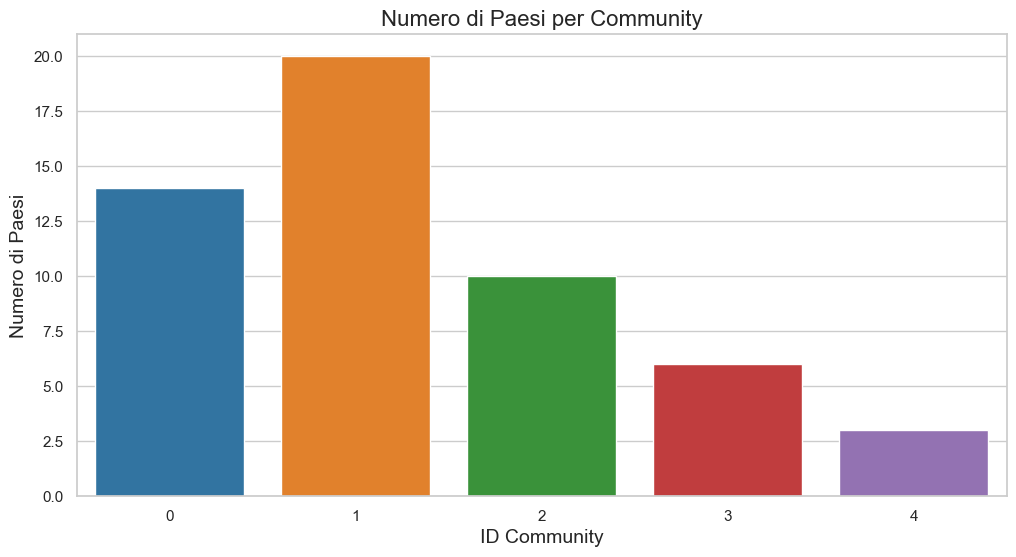


Composizione delle Community (Top 5 per dimensione):

Community 1 (20 paesi):
Canada, Germany, Russia, Indonesia, Netherlands, Austria, Azerbaijan, Belarus, Bulgaria, Czechia, Denmark, Estonia, Italy, Kazakhstan, Lithuania...

Community 0 (14 paesi):
China, Australia, France, Hong Kong, Japan, Malaysia, New Zealand, Philippines, Singapore, Taiwan, Thailand, United Kingdom, Spain, Afghanistan

Community 2 (10 paesi):
United States, Vietnam, Iran, Bahrain, Israel, Saudi Arabia, Syria, Lebanon, Palestine, Belgium

Community 3 (6 paesi):
India, South Korea, Bangladesh, North Korea, South Africa, Pakistan

Community 4 (3 paesi):
United Arab Emirates, Qatar, Turkey


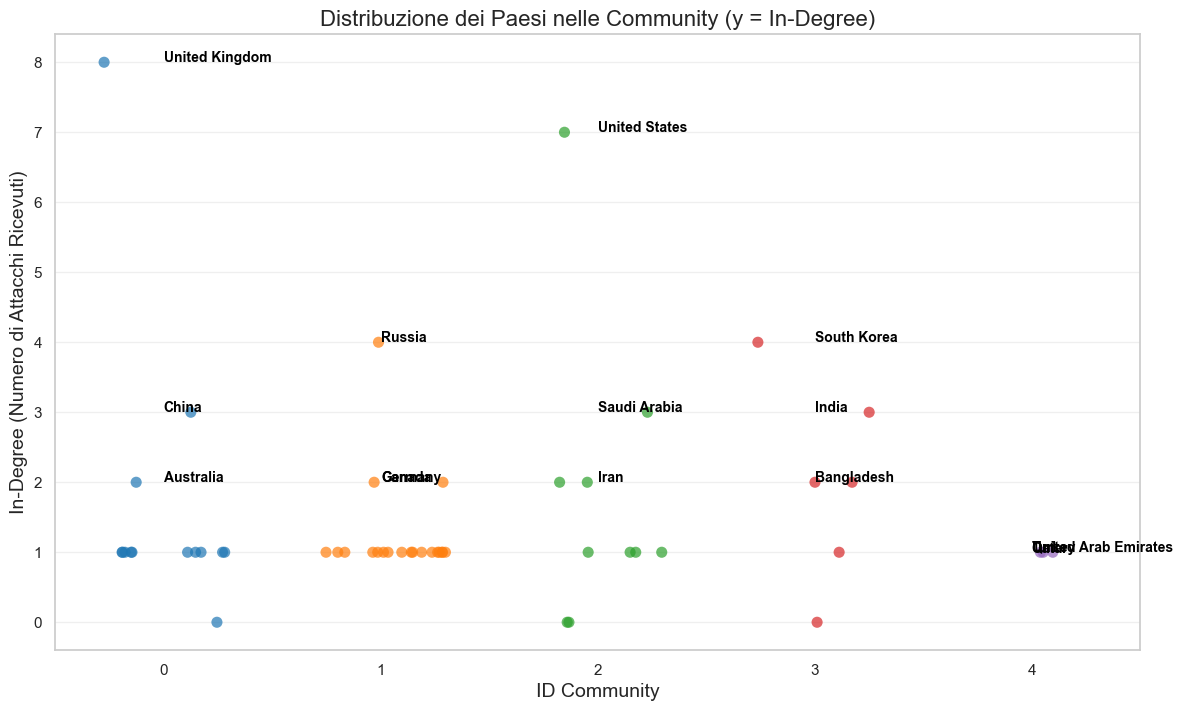

In [6]:
# 5. Rilevamento delle Community (Louvain Algorithm) e Composizione
# Identifichiamo gruppi di paesi che interagiscono più frequentemente tra loro.

# L'algoritmo di Louvain lavora meglio su grafi non orientati per la modularità standard
partition = community_louvain.best_partition(G_undirected, weight='weight')

# Aggiungiamo l'informazione della community al DataFrame delle metriche
metrics_df['Community'] = metrics_df['Country'].map(partition)

# Statistiche delle community
community_counts = metrics_df['Community'].value_counts()
num_communities = len(community_counts)

print(f"Numero di community rilevate: {num_communities}")
print("\nDimensioni delle community (Top 5):")
print(community_counts.head())

# Visualizzazione composizione community (Conteggio)
plt.figure(figsize=(12, 6))
sns.barplot(x=community_counts.index, y=community_counts.values, palette='tab10')
plt.title('Numero di Paesi per Community')
plt.xlabel('ID Community')
plt.ylabel('Numero di Paesi')
plt.show()

# Visualizzazione dei paesi per community (Tabella/Lista)
print("\nComposizione delle Community (Top 5 per dimensione):")
for com_id in community_counts.head(5).index:
    countries = metrics_df[metrics_df['Community'] == com_id]['Country'].tolist()
    print(f"\nCommunity {com_id} ({len(countries)} paesi):")
    print(", ".join(countries[:15]) + ("..." if len(countries) > 15 else ""))

# Visualizzazione Grafica della Composizione (Swarmplot per vedere i paesi)
plt.figure(figsize=(14, 8))
# Ordiniamo per community
metrics_df_sorted = metrics_df.sort_values('Community')
sns.stripplot(x='Community', y='In_Degree_Raw', data=metrics_df_sorted, 
              hue='Community', palette='tab10', jitter=0.3, size=8, alpha=0.7, legend=False)

# Etichettiamo i paesi più importanti in ogni community
for com_id in community_counts.head(5).index:
    top_countries = metrics_df[metrics_df['Community'] == com_id].nlargest(3, 'In_Degree_Raw')
    for _, row in top_countries.iterrows():
        plt.text(row['Community'], row['In_Degree_Raw'], row['Country'], 
                 horizontalalignment='left', size='small', color='black', weight='semibold')

plt.title('Distribuzione dei Paesi nelle Community (y = In-Degree)', fontsize=16)
plt.xlabel('ID Community')
plt.ylabel('In-Degree (Numero di Attacchi Ricevuti)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

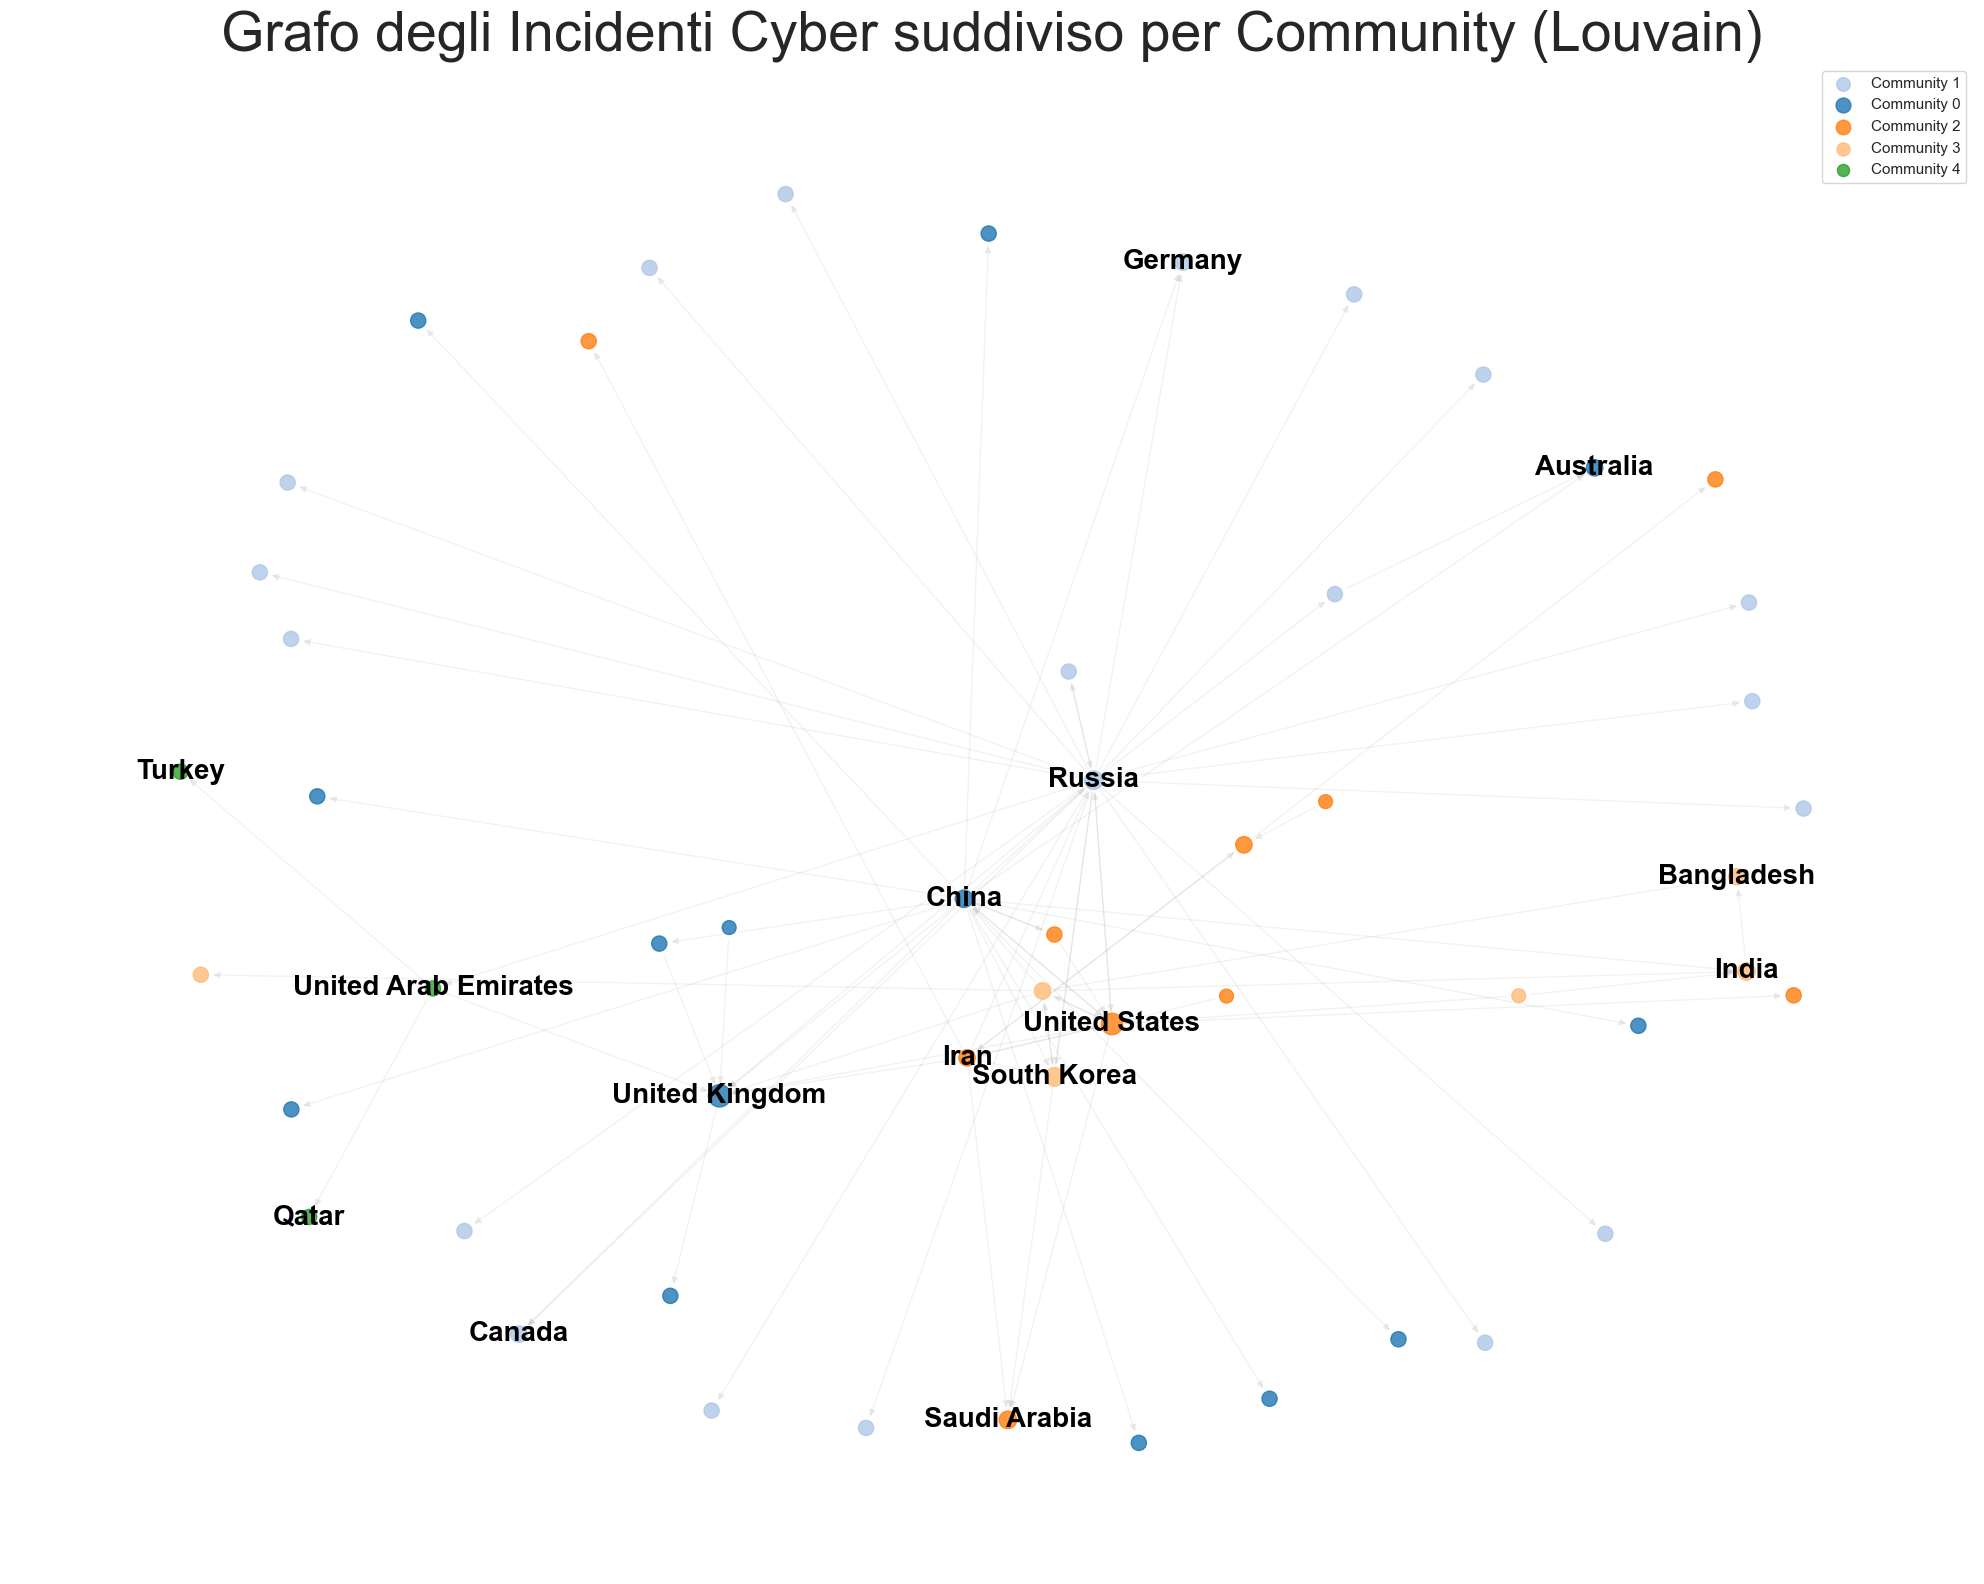

In [7]:
# 6. Visualizzazione del Grafo con Community
# Disegniamo il grafo colorando i nodi in base alla loro community di appartenenza

plt.figure(figsize=(20, 16))

# Layout
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Colori per le community
cmap = plt.get_cmap('tab20')

# Disegno nodi
for com_id in community_counts.index:
    nodes_in_com = [n for n, c in partition.items() if c == com_id]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_com, 
                           node_size=100 + metrics_df[metrics_df['Community']==com_id]['In_Degree_Raw']*20,
                           node_color=[cmap(com_id)], 
                           label=f"Community {com_id}", alpha=0.8)

# Disegno archi (più sottili e trasparenti per pulizia)
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

# Etichette per i nodi più importanti (es. top 3 per degree in ogni community grande)
labels_to_draw = {}
for com_id in community_counts.head(5).index:
    top_nodes = metrics_df[metrics_df['Community'] == com_id].nlargest(3, 'In_Degree_Raw')['Country']
    for node in top_nodes:
        labels_to_draw[node] = node

nx.draw_networkx_labels(G, pos, labels=labels_to_draw, font_size=20, font_weight='bold')

plt.title('Grafo degli Incidenti Cyber suddiviso per Community (Louvain)', fontsize=40)
plt.legend(markerscale=0.8, loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()

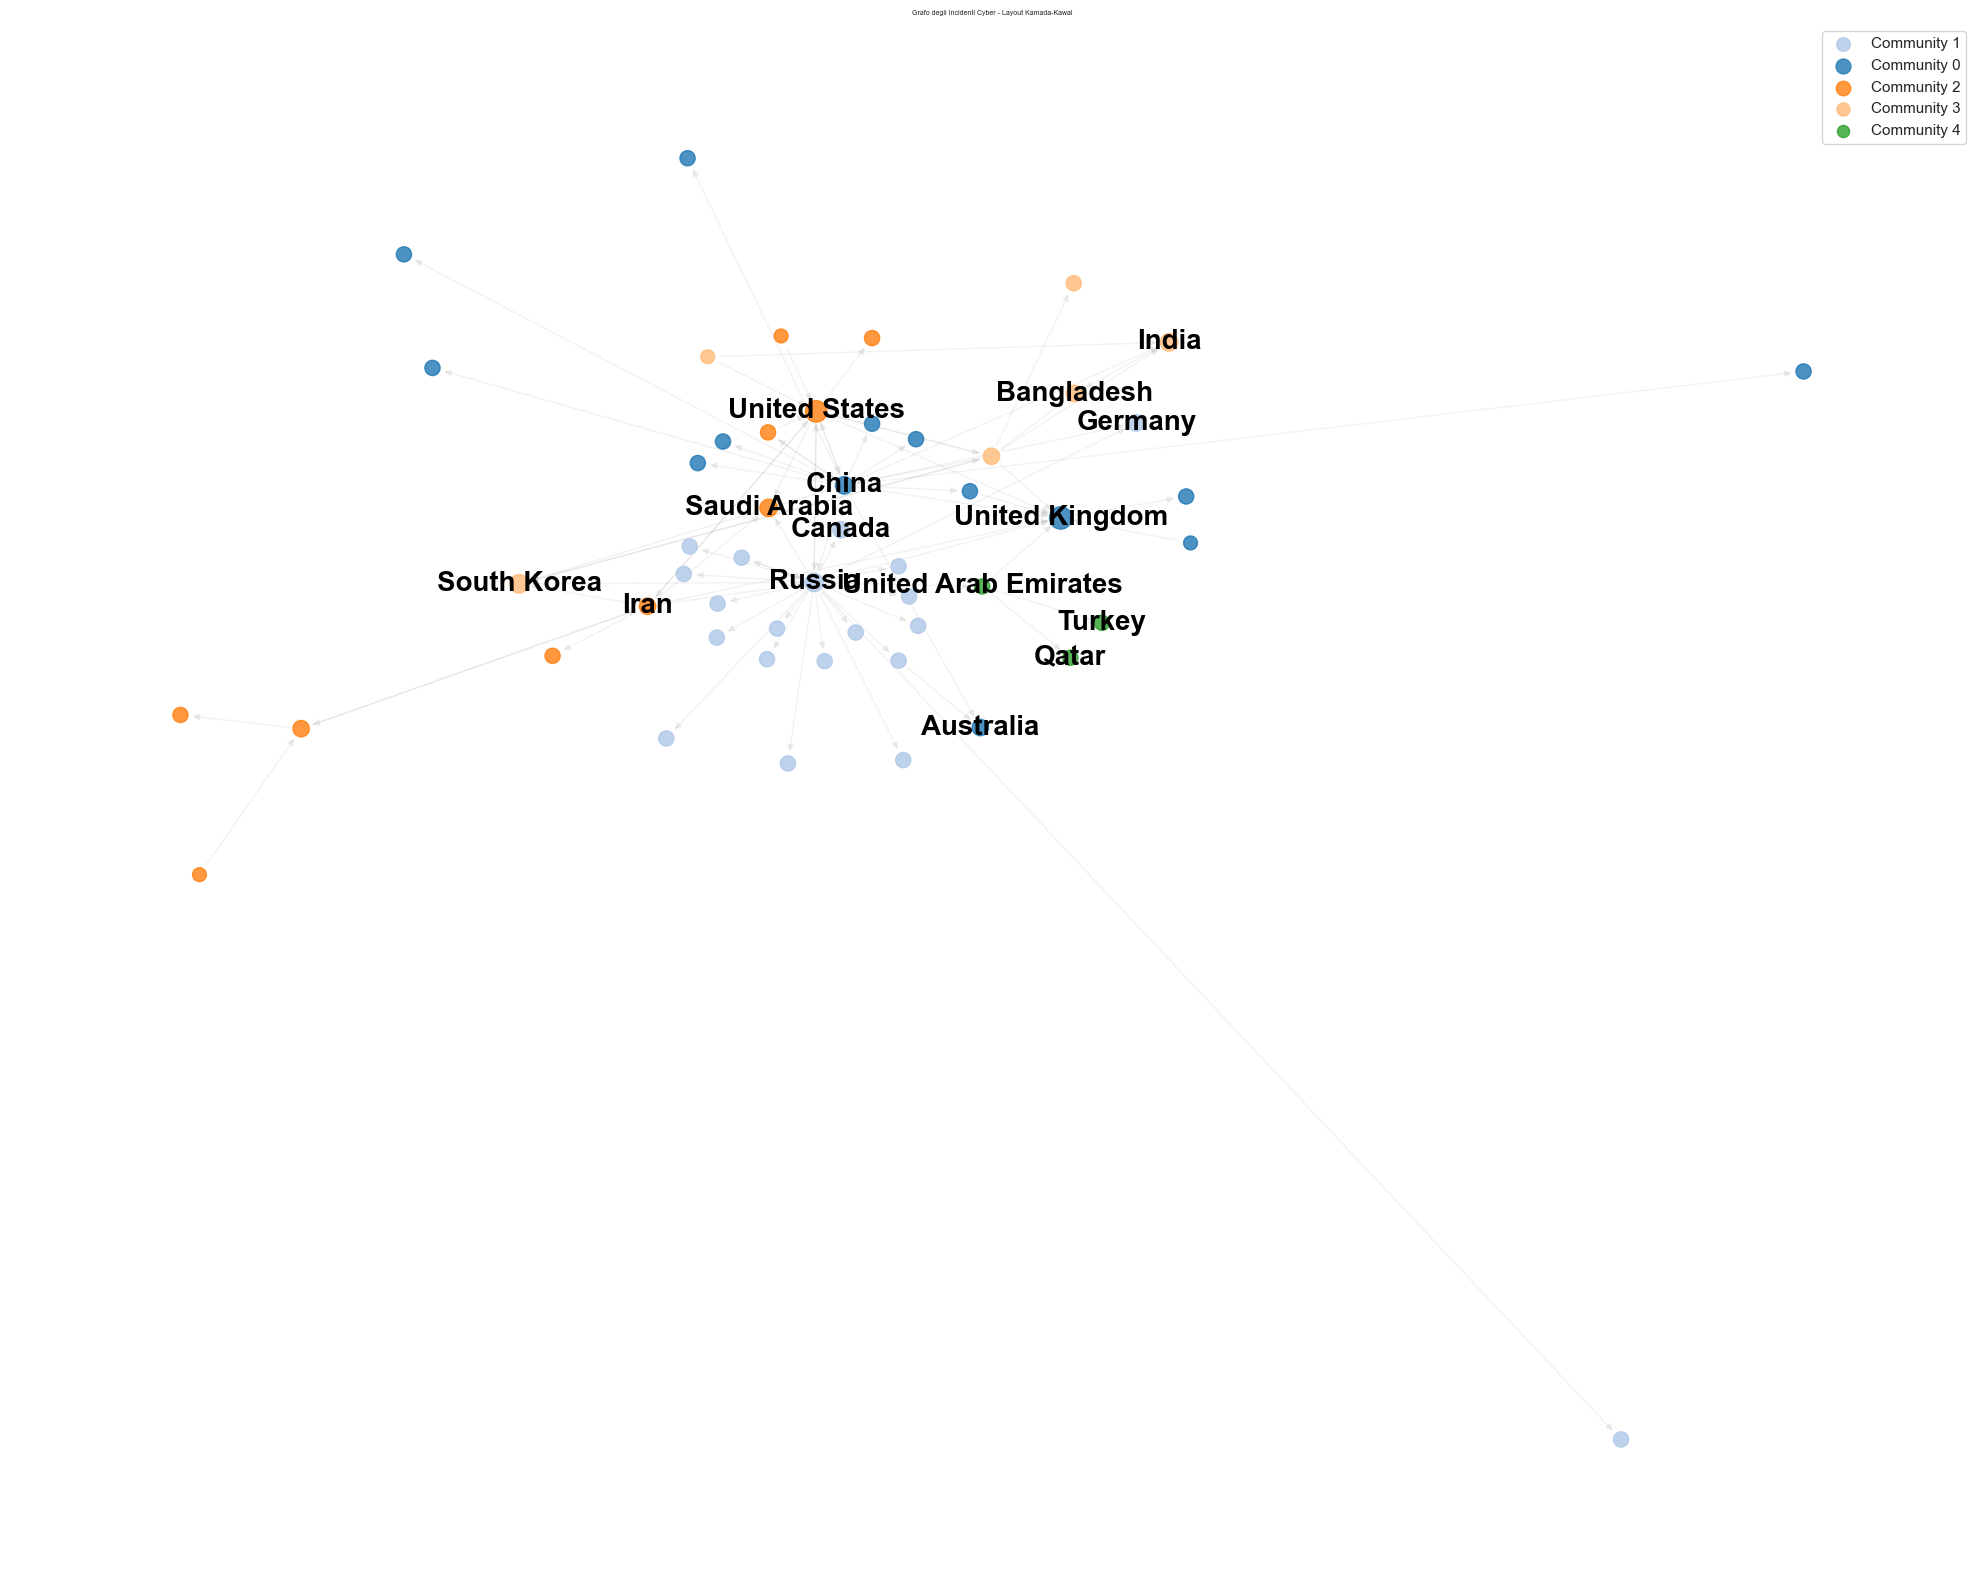

In [8]:
# 6b. Visualizzazione Alternativa con Layout Kamada-Kawai
# Il layout Kamada-Kawai spesso separa meglio le strutture di community basandosi sulla distanza nel grafo.

plt.figure(figsize=(20, 16))

# Calcolo layout Kamada-Kawai (richiede grafo non orientato per le distanze)
# Usiamo G_undirected che abbiamo creato prima
try:
    pos_kk = nx.kamada_kawai_layout(G_undirected)
    
    # Disegno nodi per community
    for com_id in community_counts.index:
        nodes_in_com = [n for n, c in partition.items() if c == com_id]
        nx.draw_networkx_nodes(G, pos_kk, nodelist=nodes_in_com, 
                               node_size=100 + metrics_df[metrics_df['Community']==com_id]['In_Degree_Raw']*20,
                               node_color=[cmap(com_id)], 
                               label=f"Community {com_id}", alpha=0.8)

    # Disegno archi
    nx.draw_networkx_edges(G, pos_kk, alpha=0.1, edge_color='gray')

    # Etichette
    nx.draw_networkx_labels(G, pos_kk, labels=labels_to_draw, font_size=20, font_weight='bold')

    plt.title('Grafo degli Incidenti Cyber - Layout Kamada-Kawai', fontsize=5)
    plt.legend(markerscale=0.8, loc='upper right')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Impossibile calcolare il layout Kamada-Kawai: {e}")
    print("Potrebbe essere necessario un grafo connesso o installare scipy.")

Analisi della Community più grande (ID: 1)
Nodi: 20
Archi interni: 20
Densità interna: 0.0526


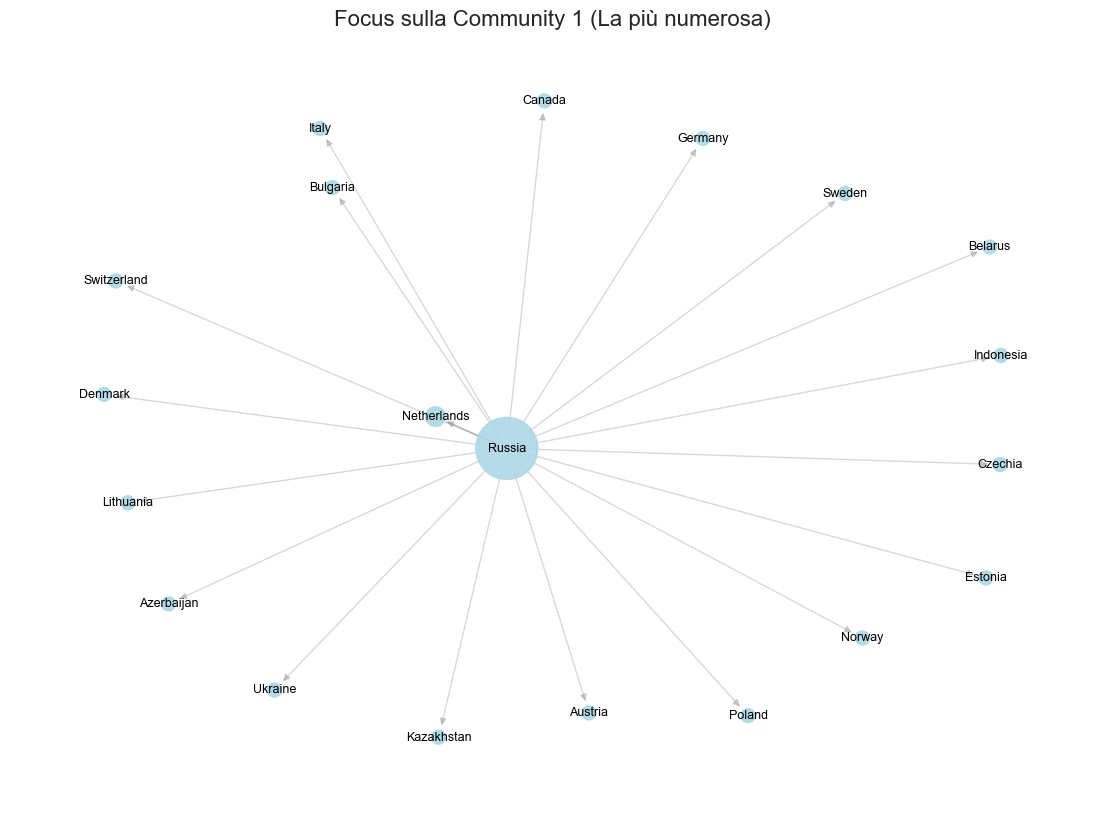

In [9]:
# 7. Analisi Approfondita della Community Principale
# Estraiamo e visualizziamo solo la community più numerosa per vedere i dettagli

largest_com_id = community_counts.idxmax()
nodes_largest_com = [n for n, c in partition.items() if c == largest_com_id]
subgraph = G.subgraph(nodes_largest_com)

print(f"Analisi della Community più grande (ID: {largest_com_id})")
print(f"Nodi: {len(nodes_largest_com)}")
print(f"Archi interni: {subgraph.number_of_edges()}")
print(f"Densità interna: {nx.density(subgraph):.4f}")

plt.figure(figsize=(14, 10))
pos_sub = nx.spring_layout(subgraph, k=0.5, seed=42)

# Dimensioni nodi basate sul degree interno al sottografo
node_sizes_sub = [v * 100 for v in dict(subgraph.degree()).values()]

nx.draw_networkx_nodes(subgraph, pos_sub, node_size=node_sizes_sub, node_color='lightblue', alpha=0.9)
nx.draw_networkx_edges(subgraph, pos_sub, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos_sub, font_size=9)

plt.title(f'Focus sulla Community {largest_com_id} (La più numerosa)', fontsize=16)
plt.axis('off')
plt.show()

Esecuzione algoritmo Girvan-Newman (potrebbe richiedere tempo)...
Analisi dei primi 5 livelli di divisione gerarchica:
Livello 1: 2 community trovate
Livello 2: 3 community trovate
Livello 3: 4 community trovate
Livello 4: 5 community trovate
Livello 5: 6 community trovate

Visualizzazione delle community al livello 5 (Girvan-Newman):


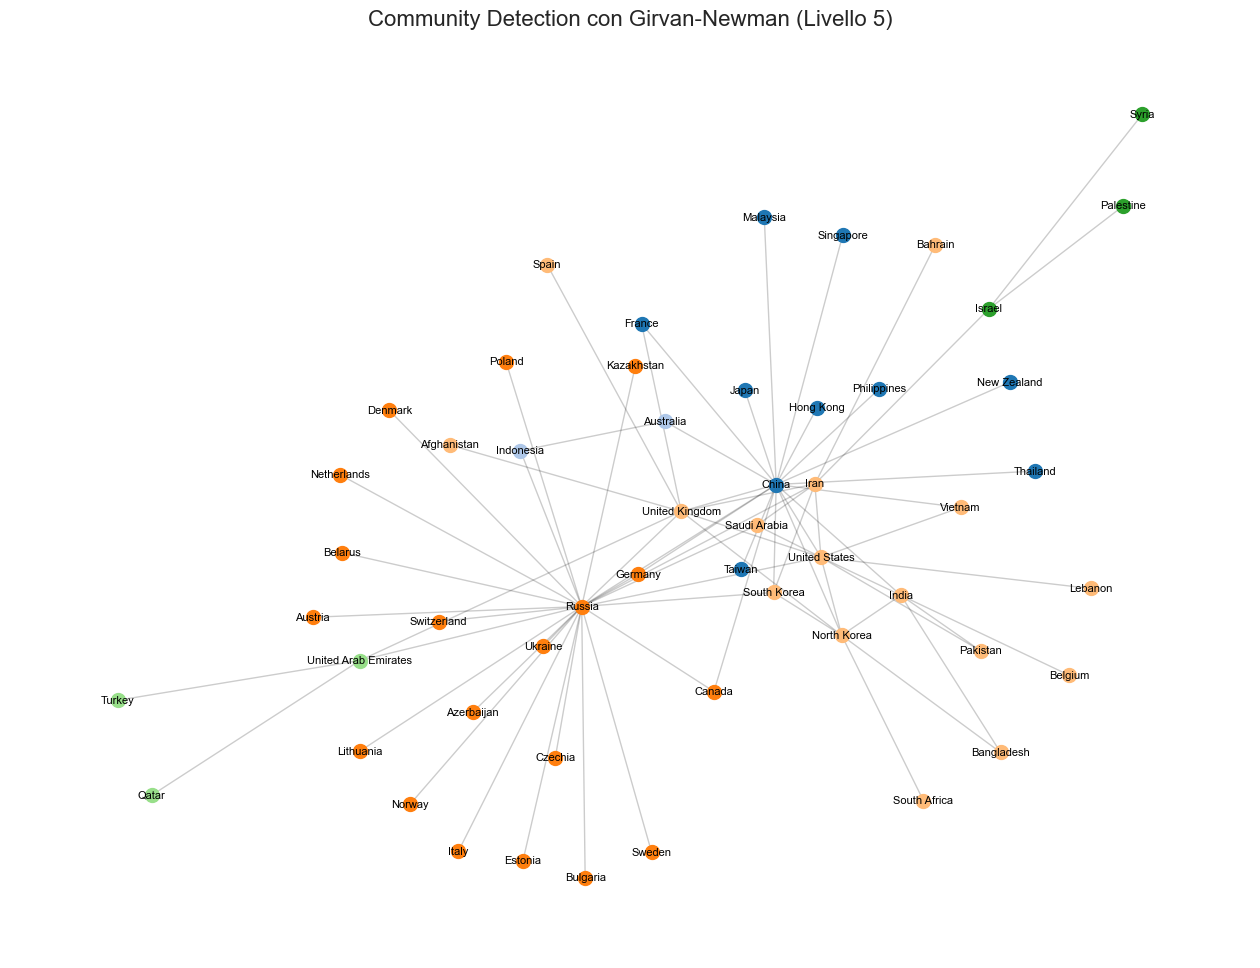

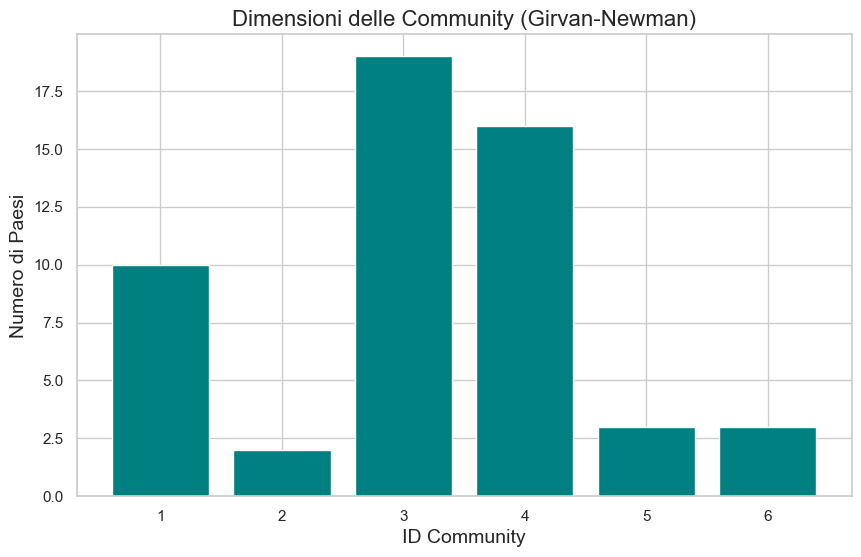

In [10]:
# 8. Analisi Community con Algoritmo Girvan-Newman
# Questo algoritmo rimuove iterativamente gli archi con la più alta betweenness centrality
# per rivelare la struttura gerarchica delle community.

print("Esecuzione algoritmo Girvan-Newman (potrebbe richiedere tempo)...")
from networkx.algorithms.community import girvan_newman

# Usiamo il grafo non orientato per semplicità e performance
comp = girvan_newman(G_undirected)

# Otteniamo la partizione al primo livello (spesso la divisione più significativa)
# Possiamo iterare per ottenere più livelli, qui prendiamo la prima divisione in k community
import itertools
k = 5 # Cerchiamo di ottenere circa k community o prendiamo i primi livelli
limited_comp = itertools.islice(comp, k)

print(f"Analisi dei primi {k} livelli di divisione gerarchica:")

level_communities = []
for i, communities in enumerate(limited_comp):
    level_communities = list(communities)
    print(f"Livello {i+1}: {len(level_communities)} community trovate")

# Visualizzazione dell'ultimo livello calcolato
print(f"\nVisualizzazione delle community al livello {k} (Girvan-Newman):")
pos_gn = nx.spring_layout(G_undirected, seed=42)
plt.figure(figsize=(16, 12))

# Assegnazione colori
cmap = plt.get_cmap('tab20')
for i, comm in enumerate(level_communities):
    color = cmap(i % 20)
    nx.draw_networkx_nodes(G_undirected, pos_gn, nodelist=list(comm), 
                           node_size=100, node_color=[color], label=f"Comm {i+1}")

nx.draw_networkx_edges(G_undirected, pos_gn, alpha=0.2)
# Etichette solo per nodi principali
nx.draw_networkx_labels(G_undirected, pos_gn, font_size=8)

plt.title(f'Community Detection con Girvan-Newman (Livello {k})', fontsize=16)
plt.axis('off')
plt.show()

# Confronto dimensioni community
gn_sizes = [len(c) for c in level_communities]
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(gn_sizes)+1), gn_sizes, color='teal')
plt.title('Dimensioni delle Community (Girvan-Newman)')
plt.xlabel('ID Community')
plt.ylabel('Numero di Paesi')
plt.show()

Analisi delle Triadi...
Numero totale di triadi chiuse (triangoli): 23
Transitività globale (Clustering Coefficient globale): 0.1060


/var/folders/5_/mnr70g2511s9w_v5w224k2x00000gn/T/ipykernel_2629/4247629196.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=triangles_series.values, y=triangles_series.index, palette='magma')


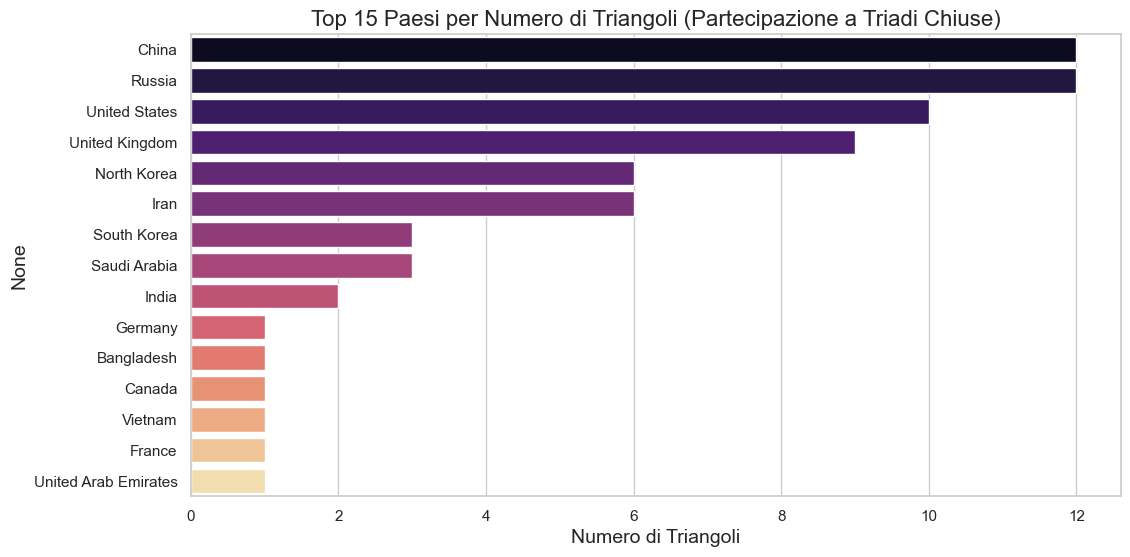

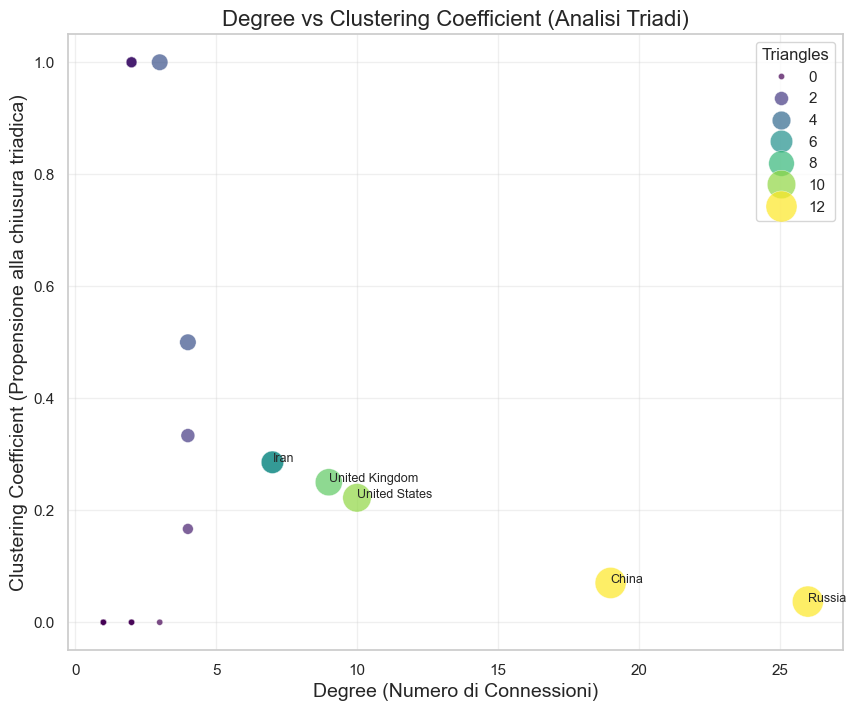

In [11]:
# 9. Analisi delle Triadi (Aperte e Chiuse)
# Le triadi sono gruppi di 3 nodi. 
# - Triade Chiusa: Tutti e 3 i nodi sono connessi tra loro (triangolo).
# - Triade Aperta: 2 nodi sono connessi a un terzo, ma non tra loro.
# Il coefficiente di clustering è legato alla proporzione di triadi chiuse.

print("Analisi delle Triadi...")

# Calcolo del numero di triangoli (triadi chiuse) per nodo
triangles = nx.triangles(G_undirected)
total_triangles = sum(triangles.values()) // 3

# Calcolo della transitività (frazione globale di triadi chiuse rispetto a tutte le triadi possibili)
transitivity = nx.transitivity(G_undirected)

print(f"Numero totale di triadi chiuse (triangoli): {total_triangles}")
print(f"Transitività globale (Clustering Coefficient globale): {transitivity:.4f}")

# Visualizzazione Triadi per Paese (Top 15)
triangles_series = pd.Series(triangles).sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=triangles_series.values, y=triangles_series.index, palette='magma')
plt.title('Top 15 Paesi per Numero di Triangoli (Partecipazione a Triadi Chiuse)')
plt.xlabel('Numero di Triangoli')
plt.show()

# Analisi Triadi Aperte vs Chiuse (Clustering Locale)
# Il clustering locale di un nodo è: (triadi chiuse a cui partecipa) / (triadi totali a cui partecipa)
clustering_coeffs = nx.clustering(G_undirected)
clustering_df = pd.DataFrame({
    'Country': list(clustering_coeffs.keys()),
    'Clustering_Coeff': list(clustering_coeffs.values()),
    'Triangles': [triangles[n] for n in clustering_coeffs.keys()]
})

# Scatter plot: Degree vs Clustering Coefficient
# Ci aiuta a capire se i nodi molto connessi sono anche molto clusterizzati (clique-like) o no (hub-spoke)
clustering_df['Degree'] = clustering_df['Country'].map(dict(G_undirected.degree()))

plt.figure(figsize=(10, 8))
sns.scatterplot(data=clustering_df, x='Degree', y='Clustering_Coeff', 
                size='Triangles', sizes=(20, 500), hue='Triangles', palette='viridis', alpha=0.7)

# Annotiamo i nodi interessanti
for _, row in clustering_df.nlargest(5, 'Degree').iterrows():
    plt.text(row['Degree'], row['Clustering_Coeff'], row['Country'], fontsize=9)
for _, row in clustering_df.nlargest(3, 'Clustering_Coeff').iterrows():
    if row['Degree'] > 5: # Solo se hanno un grado decente
        plt.text(row['Degree'], row['Clustering_Coeff'], row['Country'], fontsize=9)

plt.title('Degree vs Clustering Coefficient (Analisi Triadi)')
plt.xlabel('Degree (Numero di Connessioni)')
plt.ylabel('Clustering Coefficient (Propensione alla chiusura triadica)')
plt.grid(True, alpha=0.3)
plt.show()

Analisi K-Core...
Massimo K-Core (Main Core) della rete: k=4


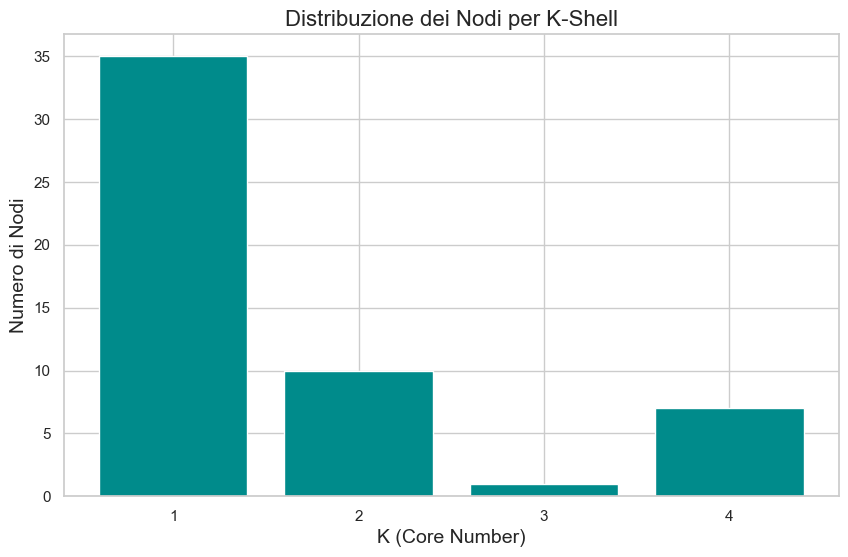


Visualizzazione del 4-Core (Nucleo più denso):
Nodi nel nucleo: 7
Archi nel nucleo: 16


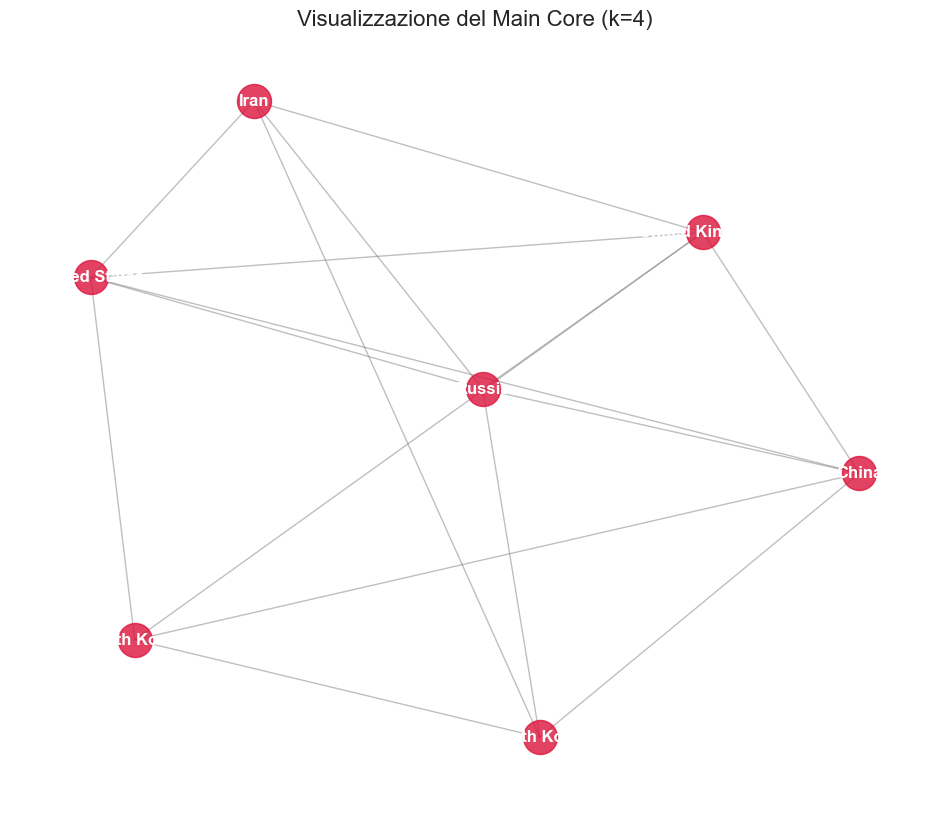

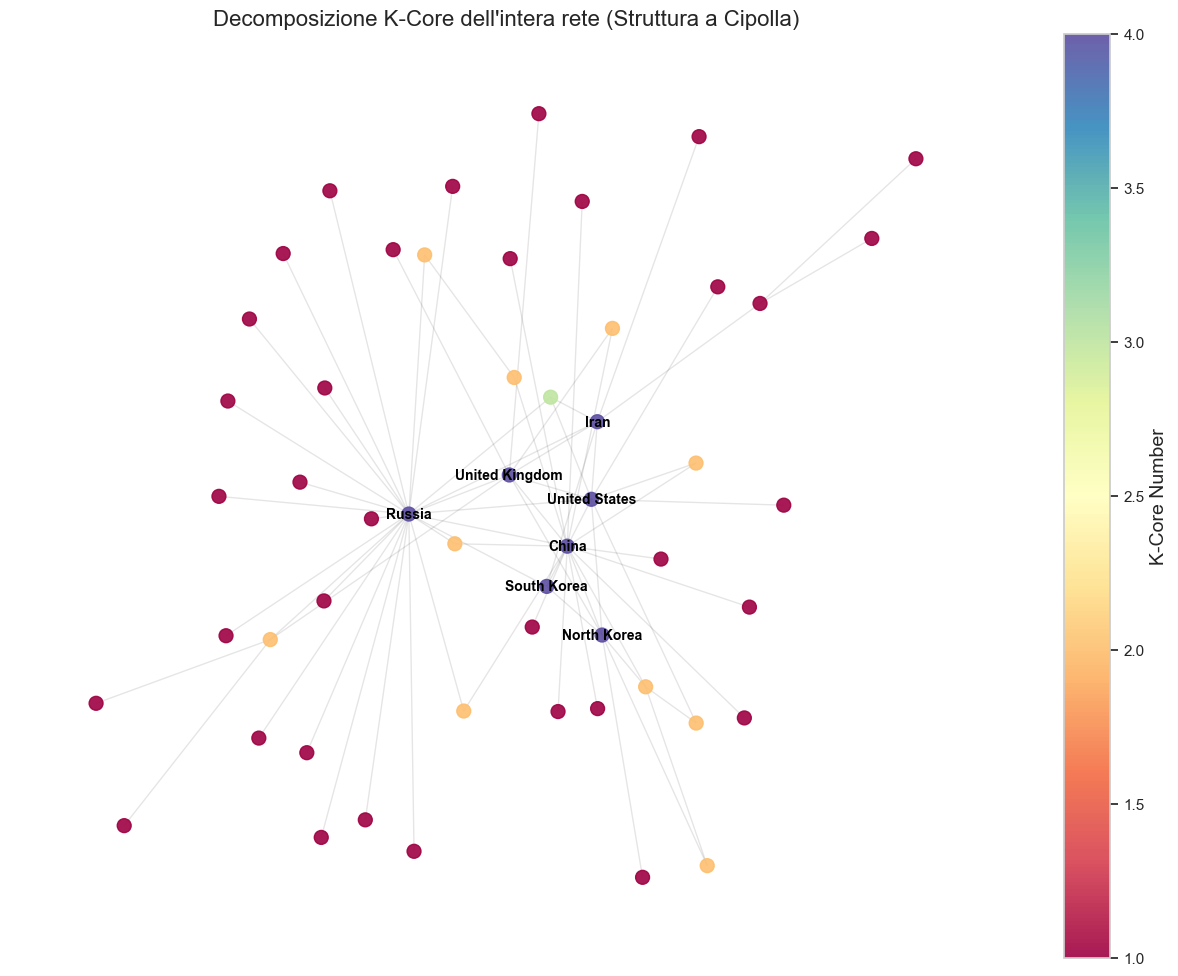

In [12]:
# 10. Analisi K-Core e Visualizzazione
# Il k-core è il sottografo massimale in cui ogni nodo ha almeno grado k all'interno del sottografo.
# È utile per identificare il "nucleo" denso della rete e rimuovere i nodi periferici.

print("Analisi K-Core...")

# Calcolo del numero di core per ogni nodo
core_numbers = nx.core_number(G_undirected)
max_k = max(core_numbers.values())
print(f"Massimo K-Core (Main Core) della rete: k={max_k}")

# Distribuzione dei nodi per k-shell
k_counts = Counter(core_numbers.values())
k_values = sorted(k_counts.keys())
counts = [k_counts[k] for k in k_values]

plt.figure(figsize=(10, 6))
plt.bar(k_values, counts, color='darkcyan')
plt.title('Distribuzione dei Nodi per K-Shell')
plt.xlabel('K (Core Number)')
plt.ylabel('Numero di Nodi')
plt.xticks(k_values)
plt.show()

# Visualizzazione del K-Core Massimo (Il nucleo più denso)
k_core_max = nx.k_core(G_undirected, k=max_k)
print(f"\nVisualizzazione del {max_k}-Core (Nucleo più denso):")
print(f"Nodi nel nucleo: {k_core_max.number_of_nodes()}")
print(f"Archi nel nucleo: {k_core_max.number_of_edges()}")

plt.figure(figsize=(12, 10))
pos_k = nx.spring_layout(k_core_max, seed=42)
nx.draw_networkx_nodes(k_core_max, pos_k, node_color='crimson', node_size=600, alpha=0.8)
nx.draw_networkx_edges(k_core_max, pos_k, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(k_core_max, pos_k, font_color='white', font_weight='bold')
plt.title(f'Visualizzazione del Main Core (k={max_k})', fontsize=16)
plt.axis('off')
plt.show()

# Visualizzazione "a cipolla" (Onion Decomposition)
# Mostriamo i nodi colorati in base al loro k-shell number nel grafo completo
plt.figure(figsize=(16, 12))
pos_full = nx.spring_layout(G_undirected, seed=42, k=0.2)

# Colormap basata sul k-core number
node_colors_k = [core_numbers[n] for n in G_undirected.nodes()]

nodes = nx.draw_networkx_nodes(G_undirected, pos_full, node_size=100, 
                               node_color=node_colors_k, cmap=plt.cm.Spectral, alpha=0.9)
nx.draw_networkx_edges(G_undirected, pos_full, alpha=0.1)
# Etichette solo per i nodi del core massimo
labels_k = {n: n for n in k_core_max.nodes()}
nx.draw_networkx_labels(G_undirected, pos_full, labels=labels_k, font_size=10, font_weight='bold')

plt.colorbar(nodes, label='K-Core Number')
plt.title('Decomposizione K-Core dell\'intera rete (Struttura a Cipolla)', fontsize=16)
plt.axis('off')
plt.show()

Analisi Ego-Network...
Analisi Ego-Network per i top 3 paesi: ['United Kingdom', 'United States', 'Russia']


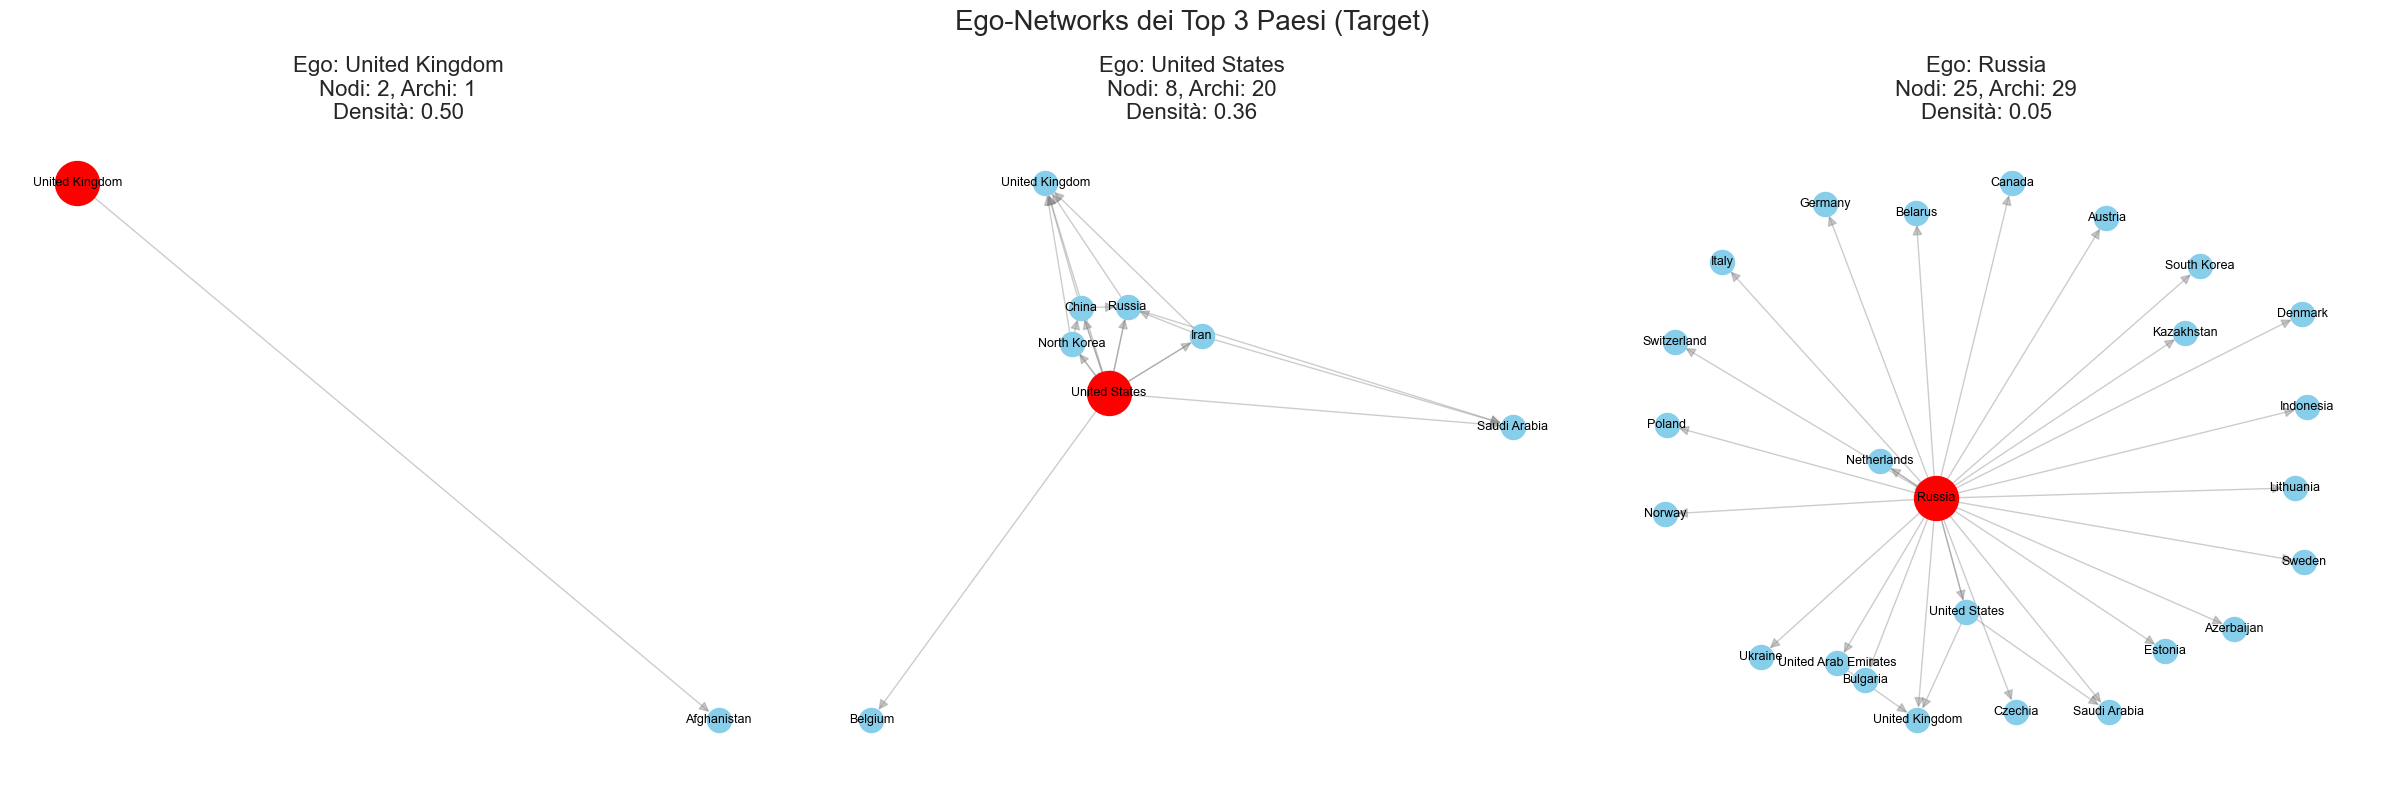


Analisi Ego-Network per i top 3 attaccanti: ['Russia', 'China', 'United States']


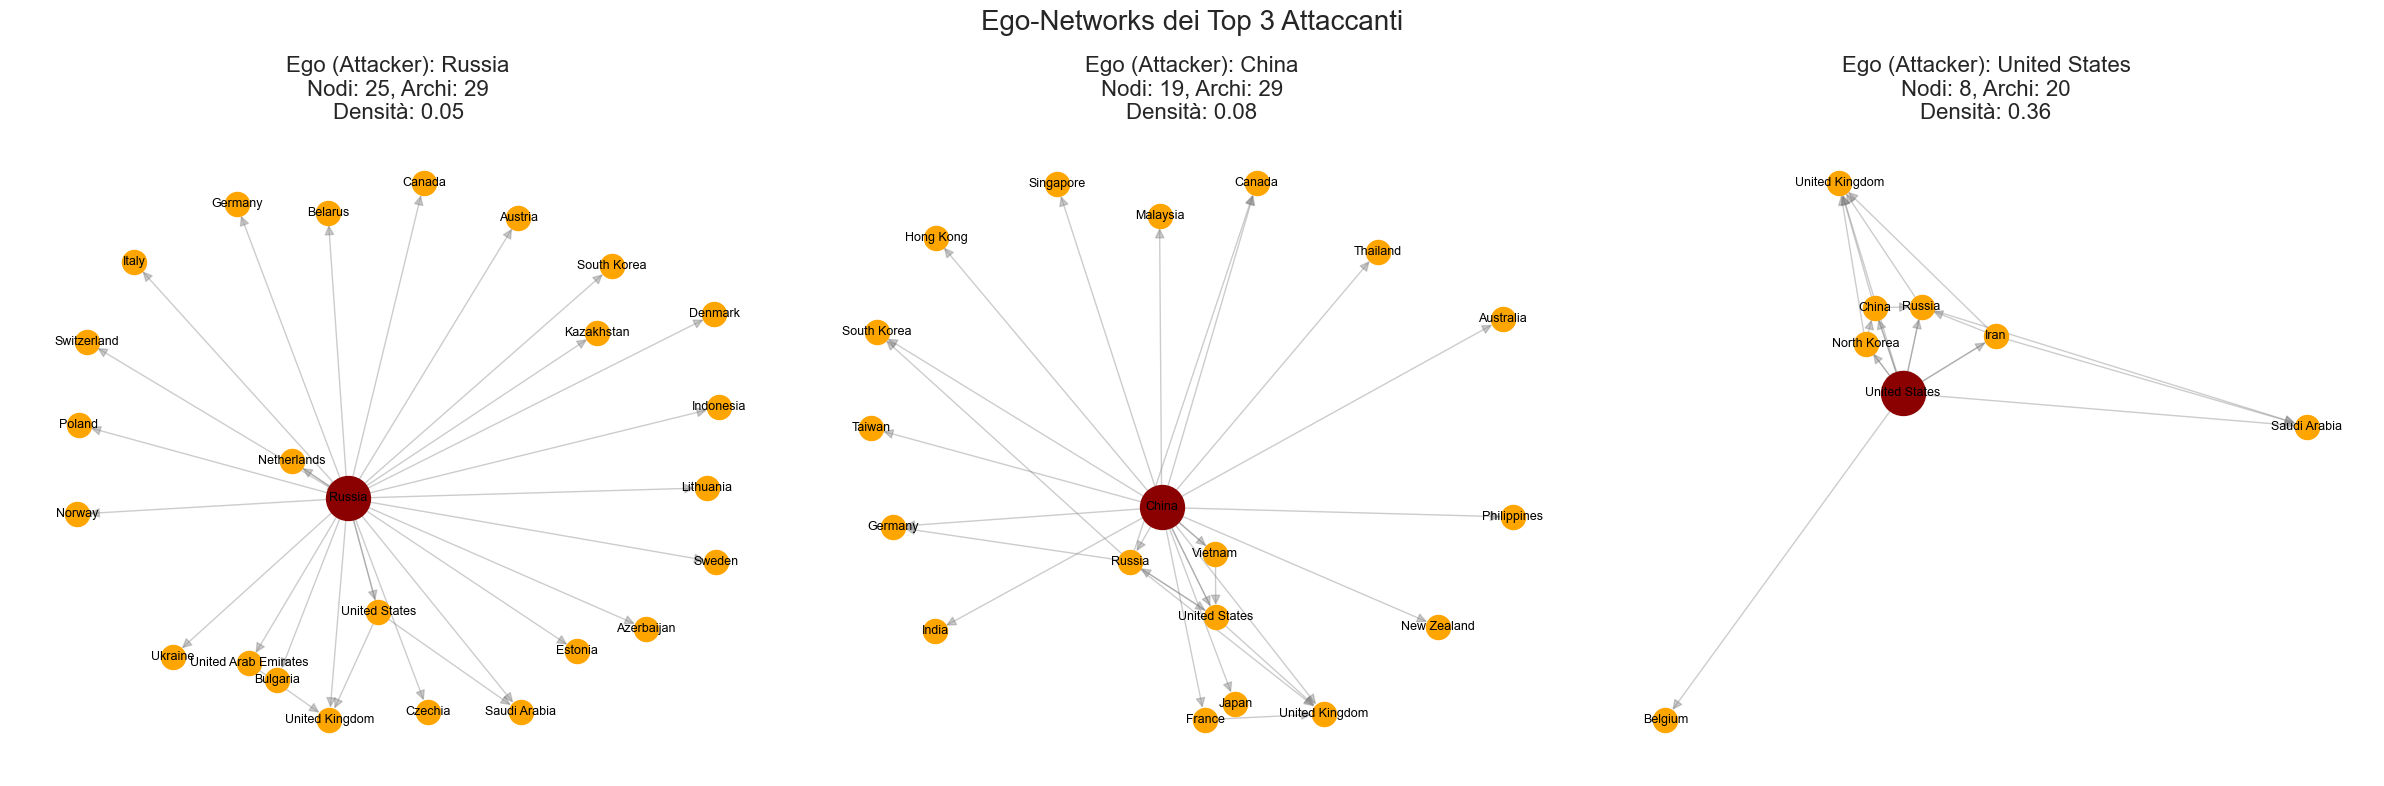

In [13]:
# 11. Analisi Ego-Network e Visualizzazione
# L'Ego-Network di un nodo (ego) è costituita dal nodo stesso, dai suoi vicini (alters) 
# e da tutte le connessioni tra questi nodi.

print("Analisi Ego-Network...")

# Selezioniamo i nodi più importanti per analizzare le loro ego-network
# Usiamo il grado totale (In + Out) come criterio
top_egos = metrics_df.nlargest(3, 'In_Degree_Raw')['Country'].tolist()
print(f"Analisi Ego-Network per i top 3 paesi: {top_egos}")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Ego-Networks dei Top 3 Paesi (Target)', fontsize=20)

for i, ego in enumerate(top_egos):
    # Creazione ego-graph (raggio 1 = vicini diretti)
    # Usiamo il grafo orientato originale G per vedere la direzione degli attacchi
    ego_G = nx.ego_graph(G, ego, radius=1)
    
    ax = axes[i]
    pos_ego = nx.spring_layout(ego_G, seed=42, k=0.5)
    
    # Disegno nodi
    # Ego in rosso e più grande
    nx.draw_networkx_nodes(ego_G, pos_ego, nodelist=[ego], node_color='red', node_size=1000, ax=ax, label='Ego')
    # Alters in blu
    alters = [n for n in ego_G.nodes() if n != ego]
    nx.draw_networkx_nodes(ego_G, pos_ego, nodelist=alters, node_color='skyblue', node_size=300, ax=ax, label='Alters')
    
    # Disegno archi
    nx.draw_networkx_edges(ego_G, pos_ego, alpha=0.4, edge_color='gray', arrowsize=15, ax=ax)
    
    # Etichette
    nx.draw_networkx_labels(ego_G, pos_ego, font_size=9, ax=ax)
    
    # Statistiche Ego-Network
    n_nodes = ego_G.number_of_nodes()
    n_edges = ego_G.number_of_edges()
    density = nx.density(ego_G)
    
    ax.set_title(f'Ego: {ego}\nNodi: {n_nodes}, Archi: {n_edges}\nDensità: {density:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Analisi Ego-Network per i Top Attaccanti
top_attackers = metrics_df.nlargest(3, 'Out_Degree_Raw')['Country'].tolist()
print(f"\nAnalisi Ego-Network per i top 3 attaccanti: {top_attackers}")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Ego-Networks dei Top 3 Attaccanti', fontsize=20)

for i, ego in enumerate(top_attackers):
    ego_G = nx.ego_graph(G, ego, radius=1)
    
    ax = axes[i]
    pos_ego = nx.spring_layout(ego_G, seed=42, k=0.5)
    
    nx.draw_networkx_nodes(ego_G, pos_ego, nodelist=[ego], node_color='darkred', node_size=1000, ax=ax)
    alters = [n for n in ego_G.nodes() if n != ego]
    nx.draw_networkx_nodes(ego_G, pos_ego, nodelist=alters, node_color='orange', node_size=300, ax=ax)
    
    nx.draw_networkx_edges(ego_G, pos_ego, alpha=0.4, edge_color='gray', arrowsize=15, ax=ax)
    nx.draw_networkx_labels(ego_G, pos_ego, font_size=9, ax=ax)
    
    n_nodes = ego_G.number_of_nodes()
    n_edges = ego_G.number_of_edges()
    density = nx.density(ego_G)
    
    ax.set_title(f'Ego (Attacker): {ego}\nNodi: {n_nodes}, Archi: {n_edges}\nDensità: {density:.2f}')
    ax.axis('off')

plt.tight_layout()
plt.show()